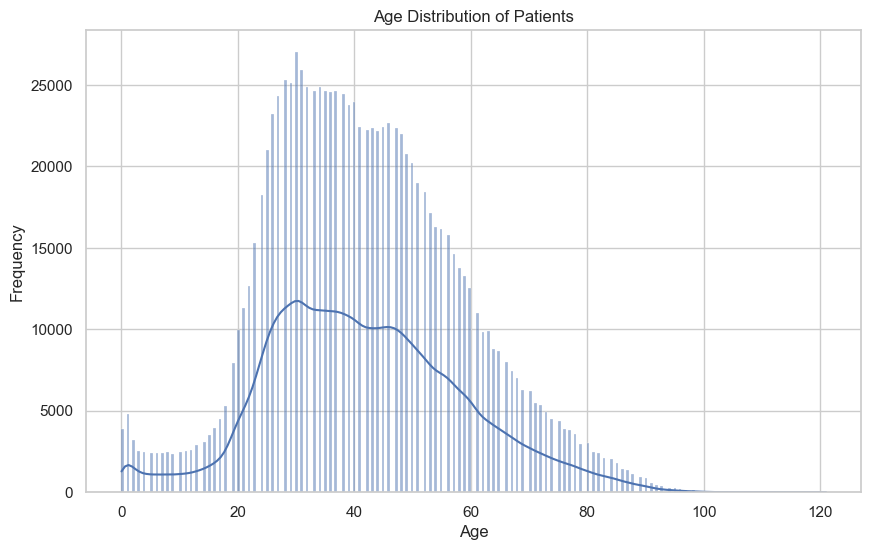

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

covid_data = pd.read_csv('Covid Data.csv')
# Setting up the visualization style
sns.set(style="whitegrid")

# Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(covid_data['AGE'], kde=True)
plt.title('Age Distribution of Patients')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


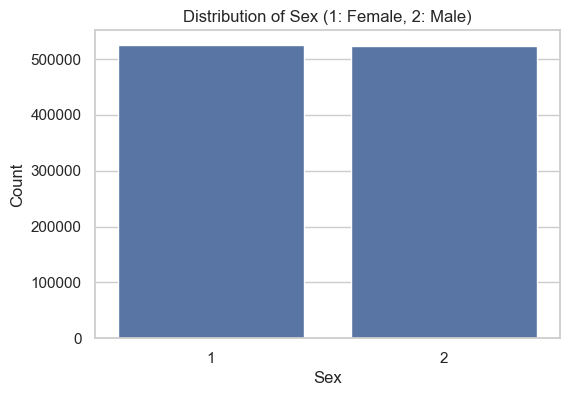

In [2]:
# Distribution of Sex
plt.figure(figsize=(6, 4))
sns.countplot(x='SEX', data=covid_data)
plt.title('Distribution of Sex (1: Female, 2: Male)')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()


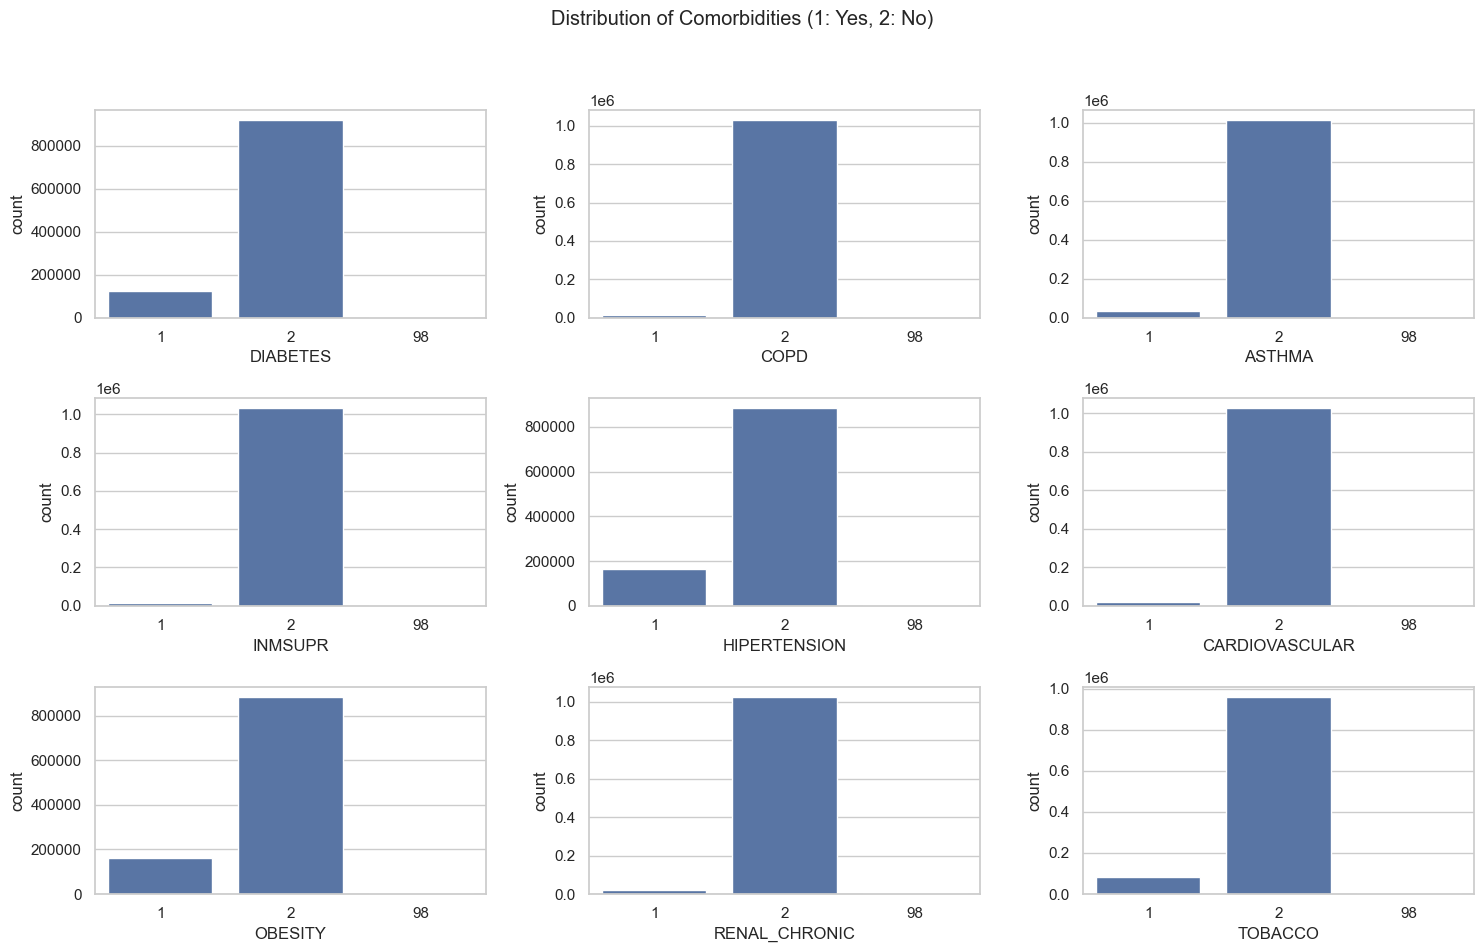

In [3]:
# 3. Distribution of Comorbidities
comorbidities = ['DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
fig.suptitle('Distribution of Comorbidities (1: Yes, 2: No)')
for i, comorbidity in enumerate(comorbidities):
    sns.countplot(x=comorbidity, data=covid_data, ax=axes[i//3, i%3])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



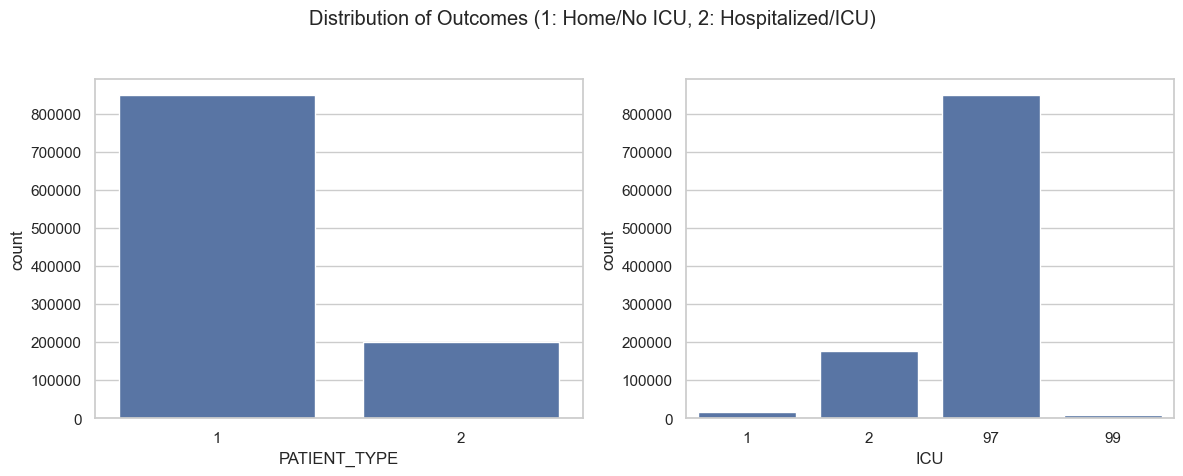

In [4]:
# Outcomes (Hospitalization, ICU admission)
outcomes = ['PATIENT_TYPE', 'ICU']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.suptitle('Distribution of Outcomes (1: Home/No ICU, 2: Hospitalized/ICU)')
for i, outcome in enumerate(outcomes):
    sns.countplot(x=outcome, data=covid_data, ax=axes[i])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



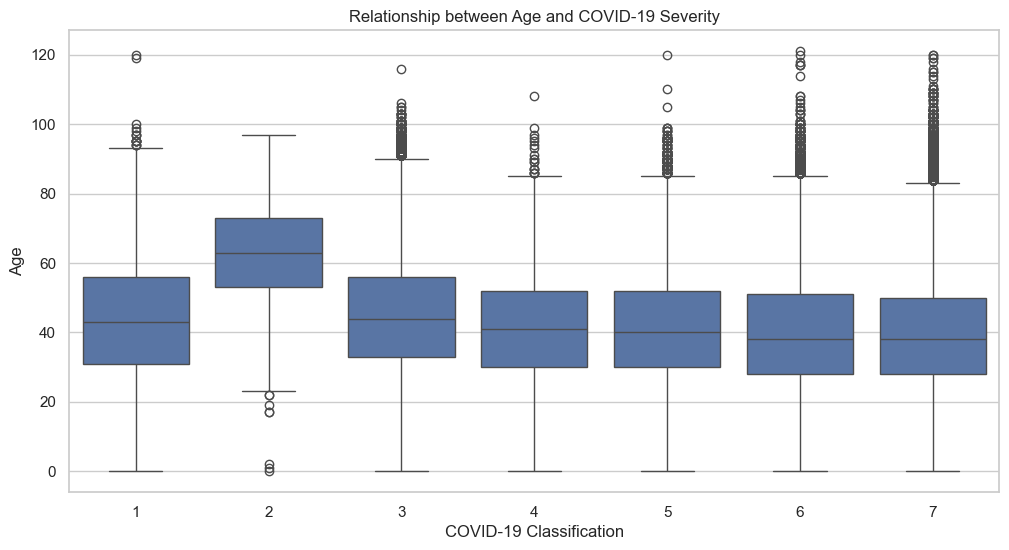

In [5]:
# Relationship between Age and COVID-19 Severity (using 'CLASIFFICATION_FINAL' as a proxy for severity)
plt.figure(figsize=(12, 6))
sns.boxplot(x='CLASIFFICATION_FINAL', y='AGE', data=covid_data)
plt.title('Relationship between Age and COVID-19 Severity')
plt.xlabel('COVID-19 Classification')
plt.ylabel('Age')
plt.show()


In [6]:
# Function to perform chi-squared test
def perform_chi2_test(data, column, outcome):
    contingency_table = pd.crosstab(data[column], data[outcome])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p

# Selecting a few variables for chi-squared tests
variables_for_test = ['SEX', 'DIABETES', 'COPD', 'ASTHMA', 'OBESITY']
outcome_variable = 'PATIENT_TYPE'  # 1 for returned home, 2 for hospitalization

# Performing chi-squared tests
chi2_results = {var: perform_chi2_test(covid_data, var, outcome_variable) for var in variables_for_test}

chi2_results

{'SEX': 0.0,
 'DIABETES': 0.0,
 'COPD': 0.0,
 'ASTHMA': 4.6165792895942357e-144,
 'OBESITY': 0.0}

In [7]:
# Preparing data for the logistic regression model
features = ['AGE', 'SEX', 'DIABETES', 'COPD', 'ASTHMA', 'OBESITY']
X = covid_data[features].fillna(0)  # Replacing missing values with 0 for simplicity
y = covid_data['PATIENT_TYPE']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Building the logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Making predictions and evaluating the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

# Print the results in a more readable format for Jupyter Notebook
print(f"Model Evaluation:\n")
print(f"Accuracy: {accuracy:.2f}\n")
print("Classification Report:")
print(classification_report_result)


Model Evaluation:

Accuracy: 0.82

Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.98      0.90    169783
           2       0.62      0.14      0.22     39932

    accuracy                           0.82    209715
   macro avg       0.72      0.56      0.56    209715
weighted avg       0.79      0.82      0.77    209715



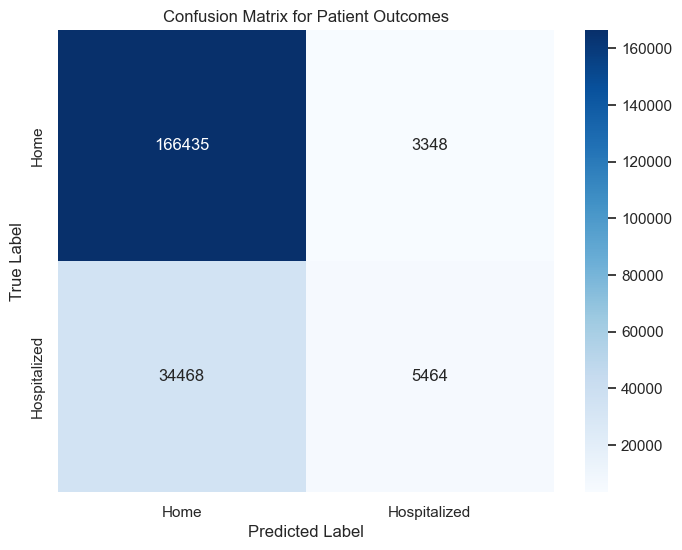

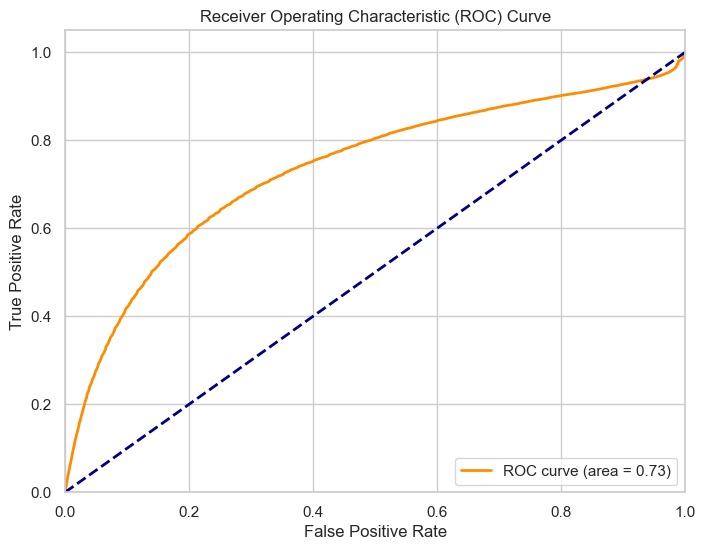

In [8]:
# Generating a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Home', 'Hospitalized'], yticklabels=['Home', 'Hospitalized'])
plt.title('Confusion Matrix for Patient Outcomes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plotting ROC Curve and calculating AUC
from sklearn.metrics import roc_curve, auc

# Calculating probabilities for the positive class
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Calculating ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=2)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Random Forest Model Evaluation:

Accuracy: 0.83

Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.95      0.90    169783
           2       0.59      0.29      0.39     39932

    accuracy                           0.83    209715
   macro avg       0.72      0.62      0.64    209715
weighted avg       0.80      0.83      0.80    209715


Gradient Boosting Model Evaluation:

Accuracy: 0.83

Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.95      0.90    169783
           2       0.60      0.28      0.39     39932

    accuracy                           0.83    209715
   macro avg       0.72      0.62      0.64    209715
weighted avg       0.80      0.83      0.80    209715


K-Nearest Neighbors Model Evaluation:

Accuracy: 0.81

Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.93      0.89    169783
         

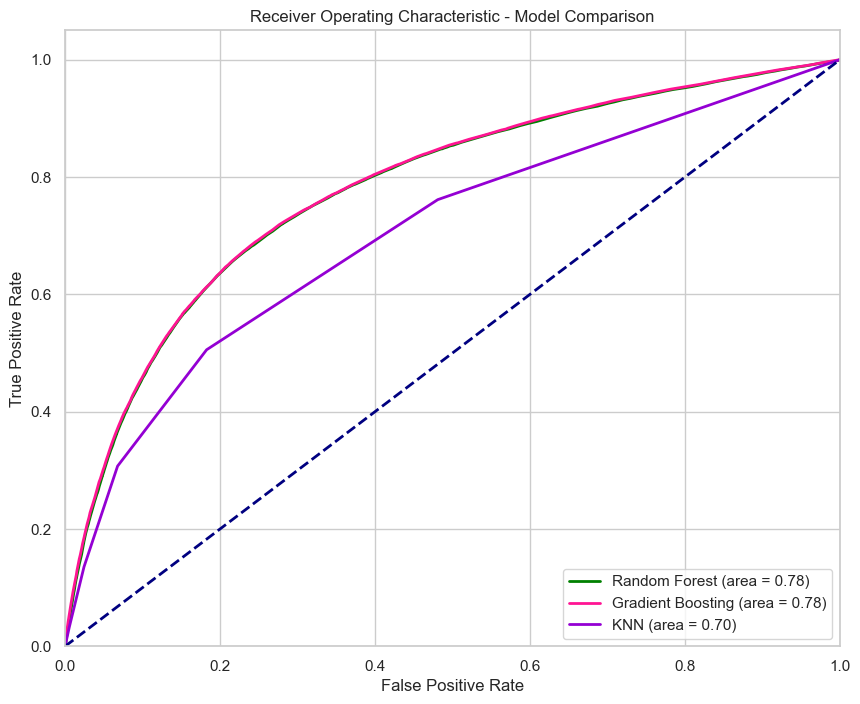

In [9]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_y_pred = rf_model.predict(X_test_scaled)

# Evaluate Random Forest Classifier
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_classification_report = classification_report(y_test, rf_y_pred)
print(f"Random Forest Model Evaluation:\n")
print(f"Accuracy: {rf_accuracy:.2f}\n")
print("Classification Report:")
print(rf_classification_report)

# Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_y_pred = gb_model.predict(X_test_scaled)

# Evaluate Gradient Boosting Classifier
gb_accuracy = accuracy_score(y_test, gb_y_pred)
gb_classification_report = classification_report(y_test, gb_y_pred)
print(f"\nGradient Boosting Model Evaluation:\n")
print(f"Accuracy: {gb_accuracy:.2f}\n")
print("Classification Report:")
print(gb_classification_report)

# K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
knn_y_pred = knn_model.predict(X_test_scaled)

# Evaluate K-Nearest Neighbors Classifier
knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_classification_report = classification_report(y_test, knn_y_pred)
print(f"\nK-Nearest Neighbors Model Evaluation:\n")
print(f"Accuracy: {knn_accuracy:.2f}\n")
print("Classification Report:")
print(knn_classification_report)

# Compare AUC for Random Forest, Gradient Boosting, and KNN
rf_y_pred_prob = rf_model.predict_proba(X_test_scaled)[:, 1]
gb_y_pred_prob = gb_model.predict_proba(X_test_scaled)[:, 1]
knn_y_pred_prob = knn_model.predict_proba(X_test_scaled)[:, 1]

# Calculate ROC Curve and AUC
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_pred_prob, pos_label=2)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_y_pred_prob, pos_label=2)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_y_pred_prob, pos_label=2)

rf_roc_auc = auc(rf_fpr, rf_tpr)
gb_roc_auc = auc(gb_fpr, gb_tpr)
knn_roc_auc = auc(knn_fpr, knn_tpr)

# Plot ROC Curves for comparison
plt.figure(figsize=(10, 8))
plt.plot(rf_fpr, rf_tpr, color='green', lw=2, label=f'Random Forest (area = {rf_roc_auc:.2f})')
plt.plot(gb_fpr, gb_tpr, color='deeppink', lw=2, label=f'Gradient Boosting (area = {gb_roc_auc:.2f})')
plt.plot(knn_fpr, knn_tpr, color='darkviolet', lw=2, label=f'KNN (area = {knn_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Model Comparison')
plt.legend(loc="lower right")
plt.show()


In [12]:
import pandas as pd

# Store the performance metrics for each model in a dictionary
model_performance = {
    'Model': ['Linear Regression','Random Forest', 'Gradient Boosting', 'K-Nearest Neighbors'],
    'Accuracy': [accuracy, rf_accuracy, gb_accuracy, knn_accuracy],
    'AUC': [roc_auc, rf_roc_auc, gb_roc_auc, knn_roc_auc]
}

# Convert the dictionary into a DataFrame for displaying as a table
performance_df = pd.DataFrame(model_performance)

# Display the DataFrame as a table
print(performance_df)


                 Model  Accuracy       AUC
0    Linear Regression  0.809589  0.734158
1        Random Forest  0.825930  0.779909
2    Gradient Boosting  0.827156  0.781847
3  K-Nearest Neighbors  0.813261  0.704024


Epoch 1/50
10486/10486 [==============================] - 6s 511us/step - loss: -1487630.8750 - accuracy: 0.8093 - val_loss: -5198317.5000 - val_accuracy: 0.8085
Epoch 2/50
10486/10486 [==============================] - 5s 470us/step - loss: -15392002.0000 - accuracy: 0.8093 - val_loss: -30111320.0000 - val_accuracy: 0.8085
Epoch 3/50
10486/10486 [==============================] - 5s 460us/step - loss: -55357896.0000 - accuracy: 0.8093 - val_loss: -87637056.0000 - val_accuracy: 0.8085
Epoch 4/50
10486/10486 [==============================] - 5s 459us/step - loss: -133980424.0000 - accuracy: 0.8093 - val_loss: -190055136.0000 - val_accuracy: 0.8085
Epoch 5/50
10486/10486 [==============================] - 5s 459us/step - loss: -263474400.0000 - accuracy: 0.8093 - val_loss: -349980608.0000 - val_accuracy: 0.8085
Epoch 6/50
10486/10486 [==============================] - 5s 461us/step - loss: -456362880.0000 - accuracy: 0.8093 - val_loss: -580236672.0000 - val_accuracy: 0.8085
Epoch 7/50
1

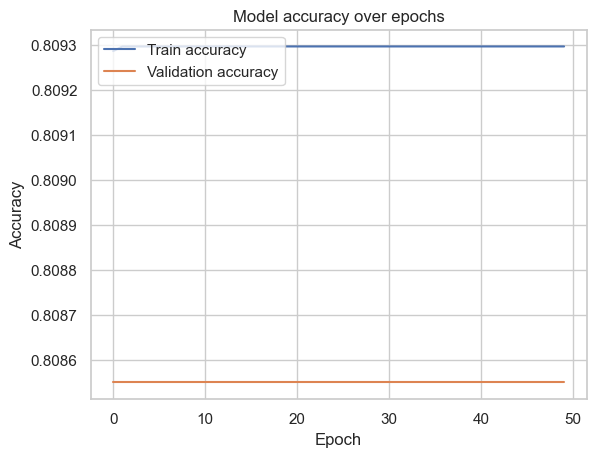

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define a simple sequential model
def create_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    return model

# Create the model using the number of features from the dataset
model = create_model(input_dim=X_train_scaled.shape[1])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Deep Learning Model Accuracy: {accuracy:.2f}")

# Plot the training history
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()